<a href="https://colab.research.google.com/github/Abhilash11Addanki/DeepLearning/blob/main/Custom%20Models(Functional%20API)/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Flatten,Dense,Dropout,Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageFont,ImageDraw
import random

In [2]:
def create_pairs(x,digit_indices):
  pairs,labels = [],[]
  n = min([len(digit_indices[d]) for d in range(10)]) - 1
  for d in range(10):
    for i in range(n):
      z1,z2 = digit_indices[d][i],digit_indices[d][i+1]
      pairs += [[x[z1],x[z2]]]
      inc = random.randrange(1,10)
      dn = (d+inc)%10
      z1,z2 = digit_indices[d][i],digit_indices[dn][i]
      pairs += [[x[z1],x[z2]]]
      labels += [1,0]
  return np.array(pairs),np.array(labels)

def create_pairs_on_set(images,labels):
  digit_indices = [np.where(labels == i)[0] for i in range(10)]
  pairs,y = create_pairs(images,digit_indices)
  y = y.astype('float32')
  return pairs,y

In [3]:
(train_images,train_labels),(test_images,test_labels) = fashion_mnist.load_data()

In [4]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images/255
test_images = test_images/255

In [5]:
tr_pairs,tr_y = create_pairs_on_set(train_images,train_labels)
ts_pairs,ts_y = create_pairs_on_set(test_images,test_labels)

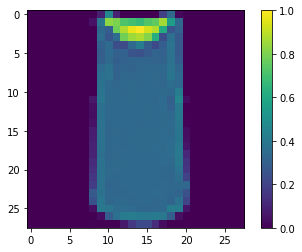

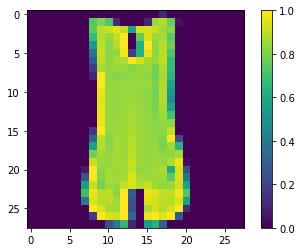

1.0


In [6]:
def show_image(image):
  plt.figure()
  plt.imshow(image)
  plt.colorbar()
  plt.grid(False)
  plt.show()

this_pair = 2
show_image(tr_pairs[this_pair][0])
show_image(tr_pairs[this_pair][1])
print(tr_y[this_pair])

In [7]:
def initialize_base_network():
  input = Input(shape=(28,28),name='base_input')
  x = Flatten(name='flatten_input')(input)
  x = Dense(128,activation='relu',name='first_dense')(x)
  x = Dropout(0.1,name='first_dropout')(x)
  x = Dense(128,activation='relu',name='second_dense')(x)
  x = Dropout(0.1,name='second_dropout')(x)
  x = Dense(128,activation='relu',name='third_dense')(x)
  return Model(inputs=input,outputs=x)

In [8]:
def euclidean_dist(vects):
  x,y = vects
  sum_square = K.sum(K.square(x-y),axis=1,keepdims=True)
  return K.sqrt(K.maximum(sum_square,K.epsilon()))

In [9]:
def euc_dist_output_shape(shapes):
  shape1,shape2 = shapes
  return (shape1[0],1)

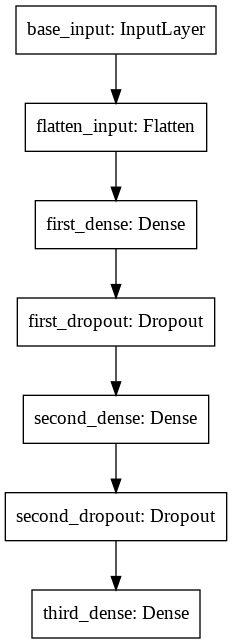

In [10]:
base_network = initialize_base_network()
plot_model(base_network)

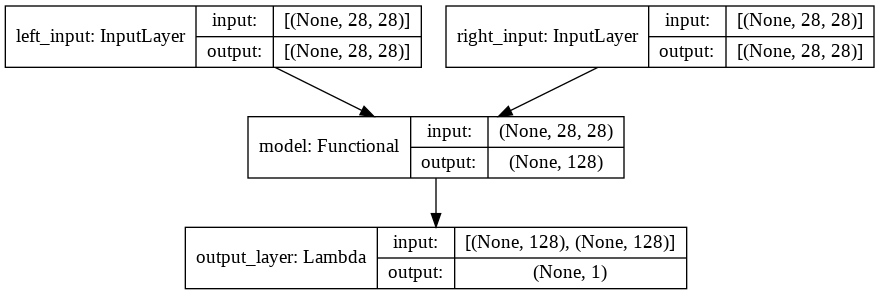

In [11]:
input_a = Input(shape=(28,28),name='left_input')
vect_out_a = base_network(input_a)
input_b = Input(shape=(28,28),name='right_input')
vect_out_b = base_network(input_b)

output = Lambda(euclidean_dist,name='output_layer',output_shape=euc_dist_output_shape)([vect_out_a,vect_out_b])
model = Model([input_a,input_b],output)

plot_model(model,show_shapes=True,show_layer_names=True)

In [12]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true,y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin-y_pred,0))
    return K.mean(y_true*square_pred+(1-y_true)*margin_square)
  return contrastive_loss

In [13]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(1),optimizer=rms)

In [14]:
history = model.fit([tr_pairs[:,0],tr_pairs[:,1]],tr_y,epochs = 20,batch_size=128,validation_data=([ts_pairs[:,0],ts_pairs[:,1]],ts_y))

Epoch 1/20
938/938 [==============================] - 6s 5ms/step - loss: 0.1547 - val_loss: 0.0842
Epoch 2/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0826 - val_loss: 0.0763
Epoch 3/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0733 - val_loss: 0.0711
Epoch 4/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0672 - val_loss: 0.0700
Epoch 5/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0645 - val_loss: 0.0671
Epoch 6/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0602 - val_loss: 0.0642
Epoch 7/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0584 - val_loss: 0.0640
Epoch 8/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0565 - val_loss: 0.0663
Epoch 9/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0557 - val_loss: 0.0634
Epoch 10/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0557 - val_loss: 0.0633

In [15]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]],y=ts_y)
print(loss)

625/625 [==============================] - 1s 2ms/step - loss: 0.0624
0.062373921275138855


In [16]:
def compute_acc(y_true,y_pred):
  pred = y_pred.ravel()>0.5
  return np.mean(pred == y_true)

In [17]:
y_pred_train = model.predict([tr_pairs[:,0],tr_pairs[:,1]])
train_acc = compute_acc(tr_y,y_pred_train)
print(train_acc)

0.05578429738289715


In [18]:
y_pred_test = model.predict([ts_pairs[:,0],ts_pairs[:,1]])
test_acc = compute_acc(ts_y,y_pred_test)
print(test_acc)

0.08438438438438438


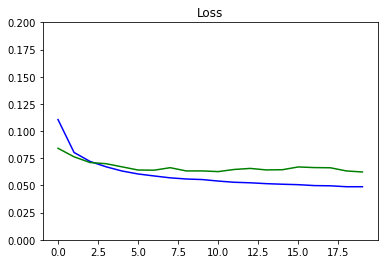

In [19]:
def plot_metrics(metric_name,title,ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_'+metric_name],color='green',label='val_'+metric_name)

plot_metrics(metric_name='loss',title='Loss',ylim=0.2)

In [20]:
def visualize_images():
  plt.rc('image',cmap='gray_r')
  plt.rc('grid',linewidth = 0)
  plt.rc('xtick',top=False,bottom=False,labelsize='large')
  plt.rc('ytick',left=False,right=False,labelsize='large')
  plt.rc('axes',facecolor='F8F8F8',titlesize='large',edgecolor='white')
  plt.rc('text',color='a8151a')
  plt.rc('figure',facecolor='F0F0F0')

def display_images(left,right,predictions,labels,title,n):
  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  plt.grid(None)
  left = np.reshape(left,[n,28,28])
  left = np.swapaxes(left,0,1)
  left = np.reshape(left,[28,28*n])
  plt.imshow(left)
  plt.figure(figsize=(17,3))
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i]>0.5:
      t.set_color('red')
  plt.grid(None)
  right = np.reshape(right,[n,28,28])
  right = np.swapaxes(right,0,1)
  right = np.reshape(right,[28,28*n])
  plt.imshow(right)

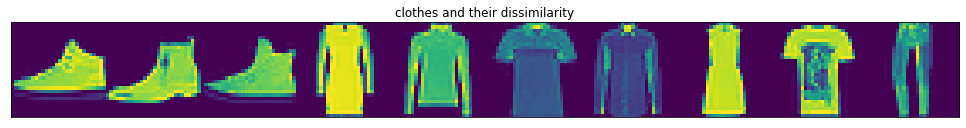

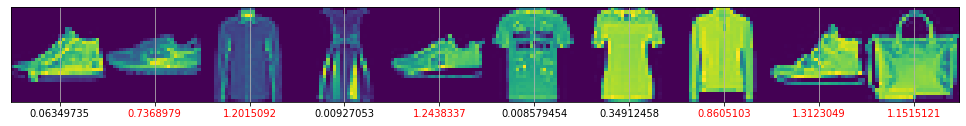

In [24]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train),size = 10)
display_images(tr_pairs[:,0][indexes],tr_pairs[:,1][indexes],y_pred_train[indexes],tr_y[indexes],"clothes and their dissimilarity",10)